In [9]:
import os
import numpy as np
import tifffile
from cellpose import models, io
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt

In [10]:
def fill_missing_cells(binary_masks_stack):
    filled_masks_stack = binary_masks_stack.copy()
    n_frames, height, width = binary_masks_stack.shape

    for i in range(1, n_frames - 1):
        prev_frame = binary_masks_stack[i - 1]
        next_frame = binary_masks_stack[i + 1]
        current_frame = binary_masks_stack[i]

        # Find cells that are missing in the current frame but present in the previous and next frames
        missing_cells = (current_frame == 0) & (prev_frame > 0) & (next_frame > 0)

        # Fill in the missing cells by interpolating between the previous and next frames
        filled_masks_stack[i][missing_cells] = 255

    return filled_masks_stack

In [ ]:
# Define folder where TIF files are located
folder = r"D:\David\endoderm_migration\raw_data\2025_09_02_stem_cells_2Dmigartion_assay_laminin\tif"
model_path = r'CP_MODEL_NUCLEI_07082024_v2'

# Define output folder for segmented masks
output_folder = r"D:\David\endoderm_migration\raw_data\2025_09_02_stem_cells_2Dmigartion_assay_laminin\cellpose_segmentation_no_fill"
os.makedirs(output_folder, exist_ok=True)

# Load Cellpose model once
# model = models.CellposeModel(gpu=True, model_type=None, pretrained_model=model_path)
model =models.CellposeModel(gpu=True, model_type='cyto3')

# Iterate over each file in the folder
for filename in os.listdir(folder):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        input_file = os.path.join(folder, filename)

        # Load the stacked TIF file
        stack = tifffile.imread(input_file)
        n_frames, height, width = stack.shape

        # List to store segmented binary masks
        binary_masks = []

        # Process each slice
        for i in range(n_frames):
            # Load a single time point
            image = stack[i]

            # Run Cellpose segmentation
            print(model.eval(image, diameter=60, channels=[0, 0]))
            masks, flows, styles = model.eval(image, diameter=60, channels=[0, 0])

            # Convert to boolean array
            binary_mask = masks > 0

            # remove small objects
            # binary_mask = remove_small_objects(binary_mask, min_size=450)

            # convert to 255,0 uint8
            binary_mask = binary_mask.astype(np.uint8) * 255

            # Append binary mask to the list
            binary_masks.append(binary_mask)

        # Convert list of binary masks to a 3D numpy array (frames, height, width)
        binary_masks_stack = np.stack(binary_masks)

        # Fill in missing cells (optional)
        # binary_masks_stack = fill_missing_cells(binary_masks_stack)

        # Define output file path
        output_filename = f"{os.path.splitext(filename)[0]}_binary_masks.tif"
        output_file = os.path.join(output_folder, output_filename)

        # Save the binary segmented masks as a TIF file
        tifffile.imwrite(output_file, binary_masks_stack)

        print(f'Binary segmented masks saved to {output_file}')

In [ ]:
len(binary_masks)

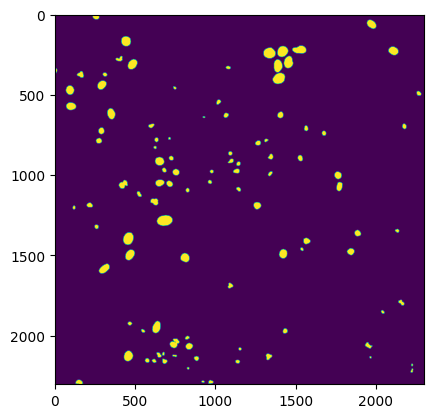

In [13]:
plt.imshow(binary_mask)